# Learning to reconstruct an image from pixel coordinates

train a neural network to learn r,g,b of each pixel of an image from x and y coordinate of each pixel

In [1]:
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

import lasagne
import theano
import theano.tensor as T

import pylab

import time

%matplotlib inline

/usr/local/lib/python3.4/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


prepare data:

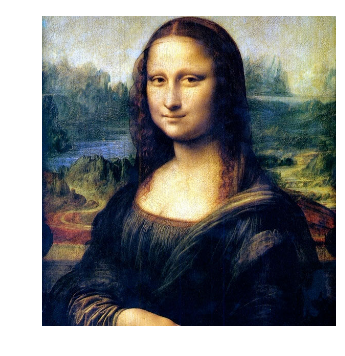

In [2]:
im = Image.open("images/monalisa.jpg")

plt.imshow(np.asarray(im))
pylab.axis('off')

im = np.asarray(im)

shape = im.shape;
 
# positions will hold the positions of all pixels
positions = np.empty([shape[0]*shape[1], 2], dtype=np.float32)

# rgb_values will hold the rgb values of all pixels
rgb_values = np.empty([shape[0]*shape[1], 3], dtype=np.float32)

for x in range(0, shape[0]):
    for y in range(0, shape[1]):
        rgb_values[x*shape[1]+y,:] = np.asarray(im)[x,y][0:3]
        positions[x*shape[1]+y,0] = float(x)/shape[0]
        positions[x*shape[1]+y,1] = float(y)/shape[1]

use highway layers from https://github.com/Lasagne/Recipes/blob/highway_networks/papers/Highway%20Networks.ipynb to allow for deeper networks:

In [3]:
class MultiplicativeGatingLayer(lasagne.layers.MergeLayer):
    """
    Generic layer that combines its 3 inputs t, h1, h2 as follows:
    y = t * h1 + (1 - t) * h2
    """
    def __init__(self, gate, input1, input2, **kwargs):
        incomings = [gate, input1, input2]
        super(MultiplicativeGatingLayer, self).__init__(incomings, **kwargs)
        assert gate.output_shape == input1.output_shape == input2.output_shape
    
    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]
    
    def get_output_for(self, inputs, **kwargs):
        return inputs[0] * inputs[1] + (1 - inputs[0]) * inputs[2]
    
def highway_dense(incoming, Wh=lasagne.init.Orthogonal(), bh=lasagne.init.Constant(0.0),
                  Wt=lasagne.init.Orthogonal(), bt=lasagne.init.Constant(-4.0),
                  nonlinearity=lasagne.nonlinearities.rectify, **kwargs):
    num_inputs = int(np.prod(incoming.output_shape[1:]))
    # regular layer
    l_h = lasagne.layers.DenseLayer(incoming, num_units=num_inputs, W=Wh, b=bh,
                               nonlinearity=nonlinearity)
    # gate layer
    l_t = lasagne.layers.DenseLayer(incoming, num_units=num_inputs, W=Wt, b=bt,
                               nonlinearity=T.nnet.sigmoid)
    
    return MultiplicativeGatingLayer(gate=l_t, input1=l_h, input2=incoming)

create the network, consisting of 2 inputs, 3 outputs and several fully connected highway layers:

In [4]:
input_data = T.matrix('X')
positions_data = T.matrix('P')
output_data = T.matrix('y')

from lasagne.nonlinearities import leaky_rectify, very_leaky_rectify, softmax, sigmoid, tanh, linear

positions_layer = lasagne.layers.InputLayer((None, 2), positions_data);

width = 20 # width of the hidden layers
depth = 15 # number of hidden layers
nl = very_leaky_rectify
init = lasagne.init.GlorotUniform()

last_hidden_layer = lasagne.layers.DenseLayer(positions_layer,
                                    width, nonlinearity=nl,
                                    W=init)

for x in range(1, depth):
    #last_hidden_layer = lasagne.layers.DenseLayer(
    #                                last_hidden_layer,
    #                                last_hidden_layer,
    #                                width, nonlinearity=nl,
    #                                W=init
    #                                )
    last_hidden_layer = highway_dense(last_hidden_layer, Wh=lasagne.init.Orthogonal(), bh=lasagne.init.Constant(0.0),
                  Wt=lasagne.init.Orthogonal(), bt=lasagne.init.Constant(-4.0),
                  nonlinearity=nl)


layer_last = lasagne.layers.DenseLayer(last_hidden_layer, 3)
                                     
reconstructed_output1 = lasagne.layers.get_output(layer_last)

loss = lasagne.objectives.squared_error(reconstructed_output1, output_data) 

loss = loss.mean()# + 1e-3 * lasagne.regularization.regularize_network_params(layer_last, lasagne.regularization.l1)

params = lasagne.layers.get_all_params(layer_last, trainable=True)
lr = theano.shared(np.float32(0.000001))
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=lr)

train_fn = theano.function([positions_data, output_data], loss, updates=updates)
loss = 0

losses = []

In [5]:
def iterate_minibatches(pos, targets, batchsize, shuffle=False):
    assert len(pos) == len(targets)
    if shuffle:
        indices = np.arange(len(pos))
        np.random.shuffle(indices)
    for start_idx in range(0, len(pos) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield pos[excerpt], targets[excerpt]

In [6]:
def save_reconstruction(iteration, width, depth):
    start = time.time()
    print("saving to " + "epoch_%04d_width_%03d_depth_%03d" % (iteration, width, depth)+".jpg")  
    reconstruct = lasagne.layers.get_output(layer_last, deterministic=True)
    reconstruct_fn = theano.function([positions_data], reconstruct)
    reconstructed = np.asarray(im).astype('float64')
    coords = np.zeros((reconstructed.shape[0]*reconstructed.shape[1],2), dtype=np.float32)
    
    for x in range(0, reconstructed.shape[0]):
        for y in range(0, reconstructed.shape[1]):
            coords[y*reconstructed.shape[0]+x] = np.array([
                           [float(x)/shape[0]],
                           [float(y)/shape[1]]
                      ]).T
    
   
    r = reconstruct_fn(coords)
    
    for x in range(0, reconstructed.shape[0]):
        for y in range(0, reconstructed.shape[1]):
            reconstructed[x,y,0:3] = r[y*reconstructed.shape[0]+x]

            if reconstructed[x,y,0] > 255:
                 reconstructed[x,y,0] = 255
            if reconstructed[x,y,1] > 255:
                 reconstructed[x,y,1] = 255
            if reconstructed[x,y,2] > 255:
                 reconstructed[x,y,2] = 255

    j = Image.fromarray(reconstructed.astype('uint8'))                                       
    j.save(("epoch_%04d_width_%03d_depth_%03d" % (iteration, width, depth))+".jpg")

train the network to map from x,y to r,g,b. after each epoch, write the resulting image to disk.

In [7]:
minibatchsize = 150

epochCounter = 0

for epoch in range(5):
    start = time.time()
    loss = 0
    loss_val = 0;
    for batch in iterate_minibatches(positions, rgb_values, minibatchsize, shuffle=True):
        pos, targets = batch
        loss += train_fn(pos, targets)
    losses.append(loss)
    print("epoch " + str(epochCounter) + " loss: " + str(loss/1000000) + " lr: " 
          + str(lr.eval()) 
          + " (" + "%.3f" % (time.time() - start) + "s)")
    
    #if epoch != 0 and epoch % 50 == 0:
    save_reconstruction(epochCounter, width, depth)
    epochCounter += 1
        
    if epoch != 0 and epoch % 25 == 0:
        lr = lr*0.1

epoch 0 loss: 27.7955189054 lr: 9.999999974752427e-07 (16.735s)
saving to epoch_0000_width_020_depth_015.jpg
epoch 1 loss: 15.9951980998 lr: 9.999999974752427e-07 (16.593s)
saving to epoch_0001_width_020_depth_015.jpg
epoch 2 loss: 4.36297294196 lr: 9.999999974752427e-07 (13.308s)
saving to epoch_0002_width_020_depth_015.jpg
epoch 3 loss: 2.49311887717 lr: 9.999999974752427e-07 (17.247s)
saving to epoch_0003_width_020_depth_015.jpg
epoch 4 loss: 2.1093921019 lr: 9.999999974752427e-07 (15.668s)
saving to epoch_0004_width_020_depth_015.jpg


show the result after 5 epochs of training:

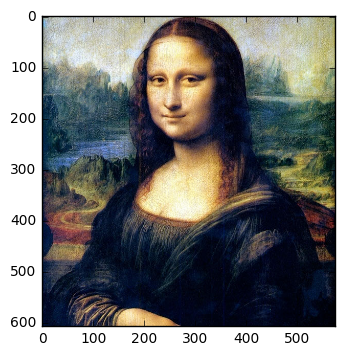

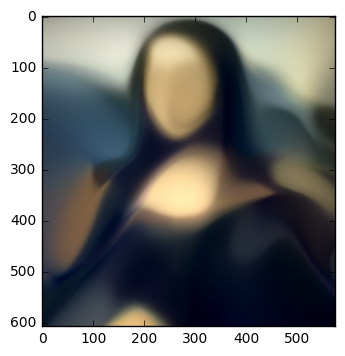

In [8]:
reconstruct = lasagne.layers.get_output(layer_last, deterministic=True)
reconstruct_fn = theano.function([positions_data], reconstruct)
reconstructed = np.asarray(im).astype('float64')

coords = np.zeros((reconstructed.shape[0]*reconstructed.shape[1],2), dtype=np.float32)
    
for x in range(0, reconstructed.shape[0]):
    for y in range(0, reconstructed.shape[1]):
        coords[y*reconstructed.shape[0]+x] = np.array([
                       [float(x)/shape[0]],
                       [float(y)/shape[1]]
                  ]).T

r = reconstruct_fn(coords)
    
for x in range(0, reconstructed.shape[0]):
    for y in range(0, reconstructed.shape[1]):
        reconstructed[x,y,0:3] = r[y*reconstructed.shape[0]+x]

        if reconstructed[x,y,0] > 255:
              reconstructed[x,y,0] = 255
        if reconstructed[x,y,1] > 255:
             reconstructed[x,y,1] = 255
        if reconstructed[x,y,2] > 255:
             reconstructed[x,y,2] = 255
                
plt.imshow(np.array(im))
pylab.figure()
plt.imshow(reconstructed.astype('uint8'))

train another 50 epochs:

In [9]:
for epoch in range(50):
    start = time.time()
    loss = 0
    loss_val = 0;
    for batch in iterate_minibatches(positions, rgb_values, minibatchsize, shuffle=True):
        pos, targets = batch
        loss += train_fn(pos, targets)
    losses.append(loss)
    print("epoch " + str(epochCounter) + " loss: " + str(loss/1000000) + " lr: " 
          + str(lr.eval()) 
          + " (" + "%.3f" % (time.time() - start) + "s)")
    
    if epochCounter % 25 == 0:
        save_reconstruction(epochCounter, width, depth)
    epochCounter += 1
        
    if epoch != 0 and epoch % 25 == 0:
        lr = lr*0.1

epoch 5 loss: 1.77575164479 lr: 9.999999974752427e-07 (19.749s)
epoch 6 loss: 1.61760110188 lr: 9.999999974752427e-07 (20.549s)
epoch 7 loss: 1.51924297185 lr: 9.999999974752427e-07 (21.897s)
epoch 8 loss: 1.46414877276 lr: 9.999999974752427e-07 (26.584s)
epoch 9 loss: 1.40934148594 lr: 9.999999974752427e-07 (21.052s)
epoch 10 loss: 1.35878021785 lr: 9.999999974752427e-07 (19.575s)
epoch 11 loss: 1.32665948048 lr: 9.999999974752427e-07 (30.501s)
epoch 12 loss: 1.29194853804 lr: 9.999999974752427e-07 (24.055s)
epoch 13 loss: 1.25314513597 lr: 9.999999974752427e-07 (20.040s)
epoch 14 loss: 1.23661047036 lr: 9.999999974752427e-07 (28.440s)
epoch 15 loss: 1.21059094795 lr: 9.999999974752427e-07 (13.898s)
epoch 16 loss: 1.19027117984 lr: 9.999999974752427e-07 (14.240s)
epoch 17 loss: 1.17368381127 lr: 9.999999974752427e-07 (13.681s)
epoch 18 loss: 1.1440998714 lr: 9.999999974752427e-07 (13.590s)
epoch 19 loss: 1.13405766216 lr: 9.999999974752427e-07 (13.588s)
epoch 20 loss: 1.12311870433 lr

show result after 55 epochs:

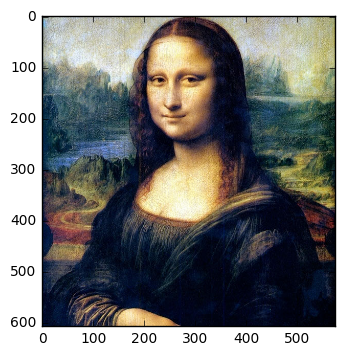

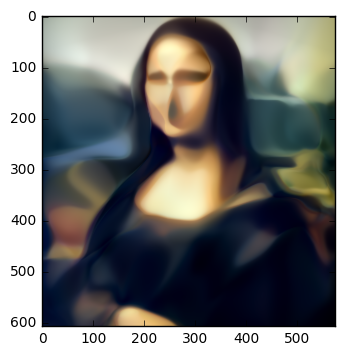

In [10]:
reconstruct = lasagne.layers.get_output(layer_last, deterministic=True)
reconstruct_fn = theano.function([positions_data], reconstruct)
reconstructed = np.asarray(im).astype('float64')

coords = np.zeros((reconstructed.shape[0]*reconstructed.shape[1],2), dtype=np.float32)
    
for x in range(0, reconstructed.shape[0]):
    for y in range(0, reconstructed.shape[1]):
        coords[y*reconstructed.shape[0]+x] = np.array([
                       [float(x)/shape[0]],
                       [float(y)/shape[1]]
                  ]).T

r = reconstruct_fn(coords)
    
for x in range(0, reconstructed.shape[0]):
    for y in range(0, reconstructed.shape[1]):
        reconstructed[x,y,0:3] = r[y*reconstructed.shape[0]+x]

        if reconstructed[x,y,0] > 255:
              reconstructed[x,y,0] = 255
        if reconstructed[x,y,1] > 255:
             reconstructed[x,y,1] = 255
        if reconstructed[x,y,2] > 255:
             reconstructed[x,y,2] = 255
                
plt.imshow(np.array(im))
pylab.figure()
plt.imshow(reconstructed.astype('uint8'))